#### Motar pasta do Google Drive ####

In [195]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Imports e pip ####

In [1]:
!pip install transformers
!pip install imbalanced-learn

In [3]:
import pandas as pd
import nltk
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn import metrics
from matplotlib import pyplot
from scipy.stats import loguniform

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
import re

ModuleNotFoundError: No module named 'pandas'

In [382]:
# termos muito frequentes que não tem relevância nos dados. São palavras que possuem apenas significado sintático dentro da sentença, porém não trazem informações relevantes sobre o seu sentido.
nltk.download('stopwords')
# RSLP Stemmer (Removedor de Sufixos da Lingua Portuguesa)
nltk.download('rslp')
# punkt é um tokenizer 
nltk.download('punkt')
# dicionário de léxicos (conjunto de vocabulários de determinado idioma) e hierarquia de termos
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#### Carregar os dados nos dataframes ####

In [383]:
df_teste = pd.read_csv('../dataset/teste.csv', sep=';', names=('texto', 'emocao'), encoding='utf-8', header=None)
df_treino = pd.read_csv('../dataset/treino.csv', sep=';', names=('texto', 'emocao'), encoding='utf-8', header=None)
df_validacao = pd.read_csv('../dataset/validacao.csv', sep=';', names=('texto', 'emocao'), encoding='utf-8', header=None)
df = pd.concat([df_treino, df_teste, df_validacao])

#### Análise dos dados (tamanho dataset, valores para emoção, dados nulos/NaN)

In [384]:
# df.count()

In [385]:
# df.head(3)

In [386]:
# %matplotlib inline
# df['emocao'].value_counts().plot(kind='bar')

In [387]:
# df['emocao'].value_counts()

In [388]:
# df_tristeza = df[df['emocao'] == 'alegria']
# df_tristeza.count()

In [389]:
# df_tristeza.head()

#### Feature Engineer:

* Análise dos dados (tamanho dataset, valores para emoção, dados nulos/NaN)
* Remover valores nulos/NAN
* Remover linhas duplicadas

In [390]:
df.isna().sum()

texto     0
emocao    9
dtype: int64

In [391]:
df = df.dropna()

In [392]:
df.isna().sum()

texto     0
emocao    0
dtype: int64

In [393]:
df.count()

texto     19995
emocao    19995
dtype: int64

In [394]:
df = df.drop_duplicates(['texto'])

In [395]:
df.count()

texto     19918
emocao    19918
dtype: int64

#### Defini funções para pre processamento

In [396]:
pontuacao = list(string.punctuation)

In [397]:
def exclui_palavras_irrelevantes(texto):
    stops = set(stopwords.words('portuguese') + pontuacao)
    palavras = [i for i in texto.split() if not i in stops]
    return (" ".join(palavras))

In [398]:
def exclui_radicais(texto):
    stemmer = nltk.stem.RSLPStemmer()
    palavras = []
    for w in texto.split():
        palavras.append(stemmer.stem(w))
    return (" ".join(palavras))

In [399]:
def exclui_pontuacao(texto):
    palavras = [i for i in texto if not i in pontuacao]
    return ("".join(palavras))

In [400]:
def lemmatization(instancia):
  wordnet_lemmatizer = WordNetLemmatizer()
  palavras = []
  for w in instancia.split():
    palavras.append(wordnet_lemmatizer.lemmatize(w))
  return (" ".join(palavras))


#### Aplica as funções de pre-processamento nos dados e split Train / Test dataset

* Avaliar o uso do Stemming (remove o radical das palavras (Ex. altera frequentemente para frenquent, imediatamente para imediat), isso pode trazer um problema pois ele pode gerar palavras que não existem no idioma.
* Avaliar o uso do Lemmatization (Ex. uma forma de Stemming que mantém a palavra com significado real (Ex. altera frequentemente para frenquente, imediatamente para imediato). O problema dessa abordagem, é que o Lemmatizer do NLTK utiliza o Dicionário da WordNet que não é específico para o Portugues

In [401]:
def pre_processing(texto, show_results=False):
    stemmer = exclui_radicais(texto)
    pont = exclui_pontuacao(stemmer)
    stops = exclui_palavras_irrelevantes(pont)
    lema = lemmatization(stops)
    # palavras = [stemmer.stem(i) for i in instancia.split() if not i in stops]
    if(show_results):
      print('Original text: {}'.format(texto))
      print('Stemmer aplicado: {}'.format(stemmer))
      print('Exclusao de pontuação aplicado: {}'.format(pont))
      print('Exclusao de stopwords aplicado: {}'.format(stops))
    return ("".join(lema))

In [402]:
df['emocao'].value_counts()

 alegria     6735
 tristeza    5779
 raiva       2698
 medo        2365
 amar        1629
 surpresa     712
Name: emocao, dtype: int64

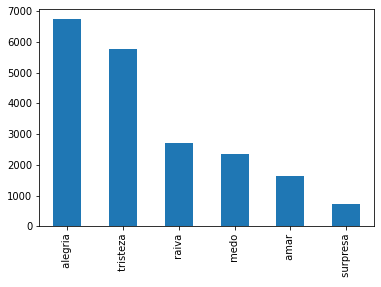

In [403]:
%matplotlib inline
df['emocao'].value_counts().plot(kind='bar')

# pyplot.plot(df['emocao'].value_counts())
# pyplot.show()

In [404]:
# df_filtered = df.loc[df['emocao'] == 'alegria'
df_filtered = df.filter(like='alegria', axis=0)
type(df_filtered)

df_filtered

# %matplotlib inline
# df_filtered['emocao'].value_counts().plot(kind='bar')

,texto,emocao


In [405]:
X = [pre_processing(i) for i in df['texto']]

In [406]:
labelencoder = LabelEncoder()
y_train_enco = labelencoder.fit_transform(df['emocao'])

# Com o uso do Undersampler a performce do modelo piora, muito provavelmente devido a grande diminuição de dados
# undersample = RandomUnderSampler()
# X_under, y_under = undersample.fit_resample(pd.DataFrame(X), pd.DataFrame(y_train_enco))
# X_train, X_test, y_train, y_test = train_test_split(X_under.squeeze(), y_under.squeeze(), random_state=41, test_size=0.2, stratify=y_under)

X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(X).squeeze(), pd.DataFrame(y_train_enco).squeeze(), random_state=41, test_size=0.2, stratify=pd.DataFrame(y_train_enco).squeeze())

In [407]:
type(y_train_enco)

numpy.ndarray

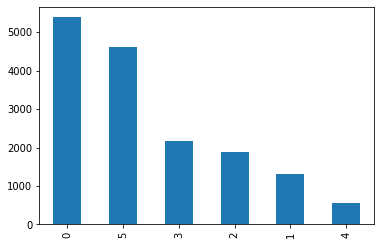

In [408]:
%matplotlib inline
y_train.value_counts().plot(kind='bar')

In [409]:
# y_under.value_counts()

In [410]:
# %matplotlib inline
# y_under.value_counts().plot(kind='bar')

In [411]:
# X_train, X_test, y_train, y_test = train_test_split(df['texto'], df['emocao'], random_state=41, test_size=0.2, stratify=df['emocao'])

# X_train = [pre_processing(i) for i in X_train]
# X_test = [pre_processing(i) for i in X_test]

# X = [pre_processing(i) for i in df['texto']]
# X_test = [pre_processing(i) for i in df['emocao']]

# y = df['emocao']
# X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(X), df['emocao'], random_state=41, test_size=0.2, stratify=df['emocao'])

#### Tokenização - Importante. Por não se tratar de uma análise de dados recuperados da internet, onde existe um linguajar específico onde é usado emoticons, hashtag, emojis e etc, para essa análise não precisamos utilizar o Tokenizer do Tweeter para tratar esse tipo de linguajar. Podemos usar o Tokenizer de palavras normais e entender que o espaço é o suficiente para separar as palavras sem afetar o sentido do textos

#### Frases e Predições de teste

In [412]:
# defina instâncias de teste dentro de uma lista
# alegria, tristeza, raiva, medo, amar, surpresa
# testes = ['eu posso ter para um deleite ou se estou me sentindo festivo',
#           'estou me sentindo muito triste e com pena de mim mesma, mas logo vou me livrar disso',
#           'estou apenas me sentindo mal-humorada e azul ',
#           'só sei que, para começar, vou me sentir tímido com isso',
#           'eu também adorei que você pudesse realmente sentir o desespero nessas sequências e eu gostei especialmente da emoção entre cavaleiro e escudeiro, já que eles estão juntos de maneira semelhante a batman e robin há muito tempo',
#           'estou me sentindo um pouco atordoada com a quantidade de itens que não uso mais para decoração']

# will_teste = ['esse Vitor Pereira é um bosta! Está ferrando o time',
#               'ainda bem que amanhã é segunda e a Thais vai acordar sem dor',
#               'eu achei que eu iria conseguir finalizar o TCC a tempo']

# will_predicao = ['raiva', 'alegria', 'surpresa']

# classe_emocoes = ['alegria', 'tristeza', 'raiva', 'medo', 'amar', 'surpresa']

# predicao_correta = ['alegria', 'tristeza', 'raiva', 'medo', 'amar', 'surpresa']

In [413]:
# testes = [pre_processing(i) for i in testes]

In [414]:
# Transforma os dados de teste em vetores de palavras.
# tfidf_vectorizer = TfidfVectorizer()
# tfidf_vectorizer.fit(X_train)
# texto_teste_vetorizado = tfidf_vectorizer.transform(testes)

In [415]:
# tfidf_vectorizer = TfidfVectorizer()
# tfidf_vectorizer.fit(X_train)
# will_teste_vetorizado = tfidf_vectorizer.transform(will_teste)

#### Vetorização dos textos

*   CountVectorizer: [BagOfWords Model] - É uma representação numérica de uma fração do texto que facilita a classificação, dessa forma o algoritmo conta a frequnência com que a palavra aparece no texto e cria um dicionário disso. Isso é chamado de Tokenization in NLP (Natural Language Processing). O CountVectorizer realiza esse processo
*   TfidfVectorizer: Transforma texto em vetores de recursos que podem ser usados ​​como entrada para o estimador



In [416]:
def get_vectorize_instance(vectorize_name):
  if(vectorize_name == 'CountVectorizer'):
    return CountVectorizer(analyzer="word")
  elif(vectorize_name == 'TfidfVectorizer'):
    return TfidfVectorizer()
  else:
    raise Exception("Vectorizer not found!")

In [417]:
def vectorize_dataframe(vectorizer, X_train, X_test):
  if(type(vectorizer) is CountVectorizer):
    train_data = vectorizer.fit_transform(X_train)
    test_data = vectorizer.transform(X_test)
    return train_data, test_data
  elif (type(vectorizer) is TfidfVectorizer):
    vectorizer.fit(X_train)
    train_data = vectorizer.transform(X_train)
    test_data = vectorizer.transform(X_test)
    return train_data, test_data
  else:
    raise Exception("Vectorizer type incorrect!")

In [418]:
def train_model(modelo, X_train, y_train):
  return modelo.fit(X_train, y_train)

In [419]:
def predict_model(modelo, X_test):
  return modelo.predict(X_test)

In [420]:
def score_model(modelo, X_test, y_test):
  return modelo.score(X_test, y_test)

In [421]:
def plot_predict_right(X_test, predictions, right_predictions, num_rows=5):
  pred = pd.DataFrame({'texto': X_test, 'predição sentimento': predictions, 'predição correta': right_predictions})
  print(pred[:num_rows])

In [422]:
def plot_classification_report(y_test, y_pred):
  print(metrics.classification_report(y_test, y_pred))

In [423]:
def avalia_modelo_score(modelo, vectorizer, X_train, X_test, y_train, y_test):
  # print('Modelo: {}'.format(type(modelo)))
  # print('Vectorizer: {}'.format(type(vectorizer)))
  train_vectorized, test_vectorized = vectorize_dataframe(vectorizer, X_train, X_test)
  model = train_model(modelo, train_vectorized, y_train)
  y_pred = predict_model(modelo, test_vectorized)
  print('Accuracy do Modelo {} com Vectorizer {} é de {:.3f}'.format(modelo, vectorizer, float(metrics.accuracy_score(y_test, y_pred))))
  print('Precision do Modelo {} com Vectorizer {} é de {:.3f}'.format(modelo, vectorizer, float(metrics.precision_score(y_test, y_pred, average='macro'))))
  print('Recall do Modelo {} com Vectorizer {} é de {:.3f}'.format(modelo, vectorizer, float(metrics.recall_score(y_test, y_pred, average='macro'))))
  print('F1-Score do Modelo {} com Vectorizer {} é de {:.3f}'.format(modelo, vectorizer, float(metrics.f1_score(y_test, y_pred, average='macro'))))
  print('\n')
  plot_classification_report(y_test, y_pred)
  return y_pred

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = loguniform(1e-5, 100)

search = RandomizedSearchCV(LogisticRegression(), space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
# search = GridSearchCV(..., scoring='accuracy', n_jobs=-1)

train_vectorized, test_vectorized = vectorize_dataframe(get_vectorize_instance('TfidfVectorizer'), X_train, X_test)

# execute search
result = search.fit(train_vectorized, y_train)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

#### Modelo Regressão Logística

In [ ]:
y_pred_lr_count_vec = avalia_modelo_score(LogisticRegression(multi_class='multinomial', solver='lbfgs'), get_vectorize_instance('CountVectorizer'), X_train, X_test, y_train, y_test)

In [ ]:
y_pred_lr_tfidf_vec = avalia_modelo_score(LogisticRegression(multi_class='multinomial', solver='lbfgs'), get_vectorize_instance('TfidfVectorizer'), X_train, X_test, y_train, y_test)

#### Modelo Multinomial Naive Bayes

In [ ]:
y_pred_mnb_count_vec = avalia_modelo_score(MultinomialNB(), get_vectorize_instance('CountVectorizer'), X_train, X_test, y_train, y_test)

In [ ]:
y_pred_mnb_tfidf_vec = avalia_modelo_score(MultinomialNB(), get_vectorize_instance('TfidfVectorizer'), X_train, X_test, y_train, y_test)

#### Modelo Random Forest

In [ ]:
y_pred_rf_count_vec = avalia_modelo_score(RandomForestClassifier(n_estimators=100), get_vectorize_instance('CountVectorizer'), X_train, X_test, y_train, y_test)

In [ ]:
y_pred_rf_tfidf_vec = avalia_modelo_score(RandomForestClassifier(n_estimators=100), get_vectorize_instance('TfidfVectorizer'), X_train, X_test, y_train, y_test)

#### Modelo SVM

In [ ]:
y_pred_svm_count_vec = avalia_modelo_score(SVC(kernel='linear'), get_vectorize_instance('CountVectorizer'), X_train, X_test, y_train, y_test)

In [ ]:
y_pred_svm_tfidf_vec = avalia_modelo_score(SVC(kernel='linear'), get_vectorize_instance('TfidfVectorizer'), X_train, X_test, y_train, y_test)

#### SGDClassifier

In [ ]:
y_pred_sgd_count_vect = avalia_modelo_score(SGDClassifier(loss="log", penalty="l2"), get_vectorize_instance('CountVectorizer'), X_train, X_test, y_train, y_test)

In [ ]:
y_pred_sgd_tfidf_vec = avalia_modelo_score(SGDClassifier(loss="log", penalty="l2"), get_vectorize_instance('TfidfVectorizer'), X_train, X_test, y_train, y_test)

#### Decision Tree

In [ ]:
y_pred_dtc_count_vec = avalia_modelo_score(DecisionTreeClassifier(criterion="gini"), get_vectorize_instance('CountVectorizer'), X_train, X_test, y_train, y_test)

In [ ]:
y_pred_dtc_tfidf_vec = avalia_modelo_score(DecisionTreeClassifier(criterion="gini"), get_vectorize_instance('TfidfVectorizer'), X_train, X_test, y_train, y_test)

#### K-Neighbors Classifier

In [ ]:
y_pred_knc_count_vec = avalia_modelo_score(KNeighborsClassifier(n_neighbors=5), get_vectorize_instance('CountVectorizer'), X_train, X_test, y_train, y_test)

In [ ]:
y_pred_knc_tfidf_vec = avalia_modelo_score(KNeighborsClassifier(n_neighbors=13), get_vectorize_instance('TfidfVectorizer'), X_train, X_test, y_train, y_test)

#### Gradient Boosting Classifier

In [ ]:
y_pred_gbc_count_vec = avalia_modelo_score(GradientBoostingClassifier(n_estimators=150), get_vectorize_instance('CountVectorizer'), X_train, X_test, y_train, y_test)

In [ ]:
y_pred_gbc_tfidfcount_vec = avalia_modelo_score(GradientBoostingClassifier(n_estimators=10), get_vectorize_instance('TfidfVectorizer'), X_train, X_test, y_train, y_test)

In [ ]:
# a, b = vectorize_dataframe(get_vectorize_instance('TfidfVectorizer'), X_train, y_train)

In [ ]:
# a

In [ ]:
# b

In [ ]:
# from sklearn.preprocessing import LabelEncoder

# labelencoder = LabelEncoder()
# y_train_enco = labelencoder.fit_transform(y_train)

# y_train_enco

In [ ]:
# scores = cross_validate(RandomForestClassifier(n_estimators=100), a, y_train_enco, cv=3, scoring='accuracy', return_train_score=True, error_score='raise')

In [ ]:
# scores

In [ ]:
# # example of grid searching key hyperparameters for gradient boosting on a classification dataset
# from sklearn.datasets import make_classification
# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import GradientBoostingClassifier
# # define dataset
# # X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=7)
# # define the model with default hyperparameters
# model = GradientBoostingClassifier()
# # define the grid of values to search
# grid = dict()
# grid['n_estimators'] = [10, 50, 100, 500]
# grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
# grid['subsample'] = [0.5, 0.7, 1.0]
# grid['max_depth'] = [3, 7, 9]
# # define the evaluation procedure
# cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=2, random_state=1)
# # define the grid search procedure
# grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
# # execute the grid search
# grid_result = grid_search.fit(a, y_train_enco)
# # summarize the best score and configuration
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# # summarize all scores that were evaluated
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

#### Unbalanced Class
#### Oversampling

In [ ]:
# from imblearn.over_sampling import SMOTE

# smote = SMOTE('minority')

# x_train_teste_smote, y_train_teste_smote = vectorize_dataframe(get_vectorize_instance('TfidfVectorizer'), X_train, y_train)

# X_smote, y_smote = smote.fit_resample(x_train_teste_smote, y_train_teste_smote)

In [ ]:
# print(pd.DataFrame(X_train).shape, pd.DataFrame(y_train).shape)

In [ ]:
# print(X_smote.shape, y_smote.shape)

In [ ]:
# y_pred_sgd_count_vect = avalia_modelo_score(SGDClassifier(loss="log", penalty="l2"), get_vectorize_instance('CountVectorizer'), X_smote, X_test, y_smote, y_test)

#### UnderSampling

In [ ]:
# type(X_under)

#### Tensor Torch

In [ ]:
# from sklearn.preprocessing import LabelEncoder
# from transformers import BertTokenizer

# labelencoder = LabelEncoder()
# df['emocao_enc'] = labelencoder.fit_transform(df['emocao'])

# df[:10]

# X_train, X_test, y_train, y_test = train_test_split(df['texto'], df['emocao_enc'], random_state=41, test_size=0.1)

In [ ]:
# ## create label and sentence list
# textos = df['texto'].values

# #check distribution of data based on labels
# print("Distribution of data based on labels: ", df['emocao_enc'].value_counts())

# # Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
# # In the original paper, the authors used a length of 512.
# MAX_LEN = 256

# ## Import BERT tokenizer, that is used to convert our text into tokens that corresponds to BERT library
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
# textos_ids = [tokenizer.encode(txt, add_special_tokens=True ,max_length=MAX_LEN, pad_to_max_length=True) for txt in textos]
# emocoes_labels = df['emocao_enc'].values

# print("\n Actual sentence before tokenization: ", textos[2])
# print("\n Encoded Input from dataset: ", textos_ids[2])

# ## Create attention mask
# attention_masks = []
# ## Create a mask of 1 for all input tokens and 0 for all padding tokens
# attention_masks = [[float(i>0) for i in seq] for seq in textos_ids]
# print('\n Attention_masks: {}'.format(attention_masks[2]))

#### Avaliador do n_stimators

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score

# #  X_train, X_test, y_train, y_test

# scores =[]
# for k in range(50, 1001, 50):
#     print('n_estimators: {}'.format(k))
#     rfc = RandomForestClassifier(n_estimators=k)
#     rfc.fit(X_train, y_train[0])
#     y_pred = rfc.predict(X_test)
#     scores.append(accuracy_score(y_test[0], y_pred))

# import matplotlib.pyplot as plt
# %matplotlib inline

# # desenha a relação entre o n_stimator com a acurácia
# # plt.plot(x_axis, y_axis)
# plt.plot(range(50, 1001, 50), scores)
# plt.xlabel('Valor do n_estimators para o Random Forest Classifier')
# plt.ylabel('Testando acuracia')

#### Criar um Classifier: é um modelo de machine learning que será usado para classificar qual tipo de emoção o texto possui (No exemplo do Siraj Raval ele utiliza uma arvore de decisão (randomForestClassifier) 

#### Opinion Minning - Sentimental Analysis, 
#### 1 - Lexicon - Análise Lexicocráfica (tokenization), nessa forma os texto são divididos em palavras e cada palavra ganha um numero de acordo com a quantidade de aparições no texto. Assim, é montado um dicionário numérico de acordo com o texto (Bag of Words) - Bag Of Words Model. Após a tokenização, o modelo olha a subjetividade da cada palavra de um lexico existente, que é uma base de dados com valores emocionais para as palavras já gravados por pesquisadores. Uma vez tendo esses valores, podemos calculadra pontuação geral da subjetividade do texto (positivo, negativo ou neutro) - Não funciona por exemplo em casos de sarcasmo
#### 2 - Machine Learning (Vectors)

#### Dados desbalanceados
#### para tratar esse tipo de dataset, podemos tomar 2 tipos de abordagem. 

#### Gerar sinteticamente novos registros (técnica de Oversampling) fazendo com que a classe que tem menor quantidade de amostras (minoritária) tenha um número maior de dados. O cuidado ao usar esse tipo de técnica pode gerar dados "dupicados" podem gerar um overfitting do modelo

#### Igualar as outras classes mioritárias com a minoritária (técnica de Undersampling). O uso dessa técnica pode gerar uma diminuição considerável no tamanho do dataset